## This notebook shows how to convert from different coordinates frames using astropy
- In particular, it is useful to plot satellites groundtracks
- It is also useful to compute communication windows

In [26]:
import numpy as np

from astropy.coordinates import (
    GCRS,
    ITRS,
    CartesianRepresentation,
    SphericalRepresentation,
)
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.time import Time

from poliastro.earth.plotting import GroundtrackPlotter

from poliastro.bodies import Earth

In [27]:
# load a trajectory
file_name = "1day.npy"
traj = np.load("propagation_results/position_vel_" + file_name)
rr = traj[:, :3]
vv = traj[:, 3:]

epochs = np.load("propagation_results/epochs_" + file_name, allow_pickle=True)

## 1. Convert to lat-lon coordinates (ITRS frame, spherical representation)

In [28]:
raw_xyz = CartesianRepresentation(rr, xyz_axis=-1)
raw_obstime = epochs
gcrs_xyz = GCRS(
    raw_xyz, obstime=raw_obstime, representation_type=CartesianRepresentation
)

# Converts raw coordinates to ITRS ones.
itrs_xyz = gcrs_xyz.transform_to(ITRS(obstime=raw_obstime))
itrs_latlon = itrs_xyz.represent_as(SphericalRepresentation)
print(itrs_latlon)

[(2.44004748,  0.00272874, 6928.1366    ),
 (2.43982988,  0.00381396, 6928.13659429),
 (2.43961228,  0.00489918, 6928.13657714), ...,
 (5.18384931, -0.79498464, 6920.96712694),
 (5.18348044, -0.79606122, 6920.9662873 ),
 (5.18311093, -0.79713776, 6920.96545065)] (rad, rad, )


## Go the other way around

In [29]:
itrs_cartesian = itrs_latlon.represent_as(CartesianRepresentation)

# Create ITRS object using the cartesian representation
itrs_xyz2 = ITRS(itrs_cartesian, obstime=raw_obstime)

# Transform from ITRS back to GCRS
gcrs_xyz2 = itrs_xyz2.transform_to(GCRS(obstime=raw_obstime))

print((gcrs_xyz2.data.xyz - gcrs_xyz.data.xyz) < 0.00001)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


## Application: check if a satellite is visible from a ground station

In [30]:
station_coords = [46.31, 6.38] * u.deg  # [LAT LON]
station_name = "Lausanne"
satellite_name = "CHESS_1"

In [31]:
# First, plot the groundtrack to be able to check results later

gp = GroundtrackPlotter()
gp.add_trace(
    go.Scattergeo(
        lat=station_coords[0],
        lon=station_coords[1],
        name=station_name,
        marker={"color": "red"},
        showlegend=True,
    )
)
gp.add_trace(
    go.Scattergeo(
        lat=itrs_latlon.lat.to(u.deg),
        lon=itrs_latlon.lon.to(u.deg),
        mode="lines",
        name=satellite_name,
        line={"color": "purple", "width": 1},
    )
)
# Customize plots
gp.update_layout(
    margin=dict(l=10, r=10, b=0, t=50),  # Set margins to zero
    height=500,
    width=800,
    legend=dict(
        title="Legend:",
        orientation="h",  # Horizontal legend
        yanchor="bottom",  # Anchor to the bottom
        y=-0,  # Position it below the plot (adjust as needed)
        xanchor="center",  # Center the legend
        x=0.5,  # Center the legend horizontally
    ),
)
gp.fig.show()
gp.update_geos(projection_type="orthographic")
gp.fig.show()

In [32]:
earth_R = Earth.R.to(u.km)  # Earth's radius (km)

# Step 1: Create a SphericalRepresentation
spherical_coords = SphericalRepresentation(
    lat=station_coords[0],
    lon=station_coords[1],
    distance=earth_R,  # Earth's average radius + height
)


# raw_xyz = CartesianRepresentation(rr, xyz_axis=-1)
# raw_obstime = epochs
# gcrs_xyz = GCRS(
#     raw_xyz, obstime=raw_obstime, representation_type=CartesianRepresentation
# )


# Step 2: Convert to CartesianRepresentation
cartesian_coords = spherical_coords.represent_as(CartesianRepresentation)
# print(cartesian_coords)
cartesian_coords = np.tile(
    cartesian_coords.xyz, (len(epochs), 1)
)  # repeat it for the number of epochs
# print(cartesian_coords)
cartesian_coords = CartesianRepresentation(cartesian_coords, xyz_axis=-1)
# print(cartesian_coords)

# Step 3: Specify obstime for ITRS
obstime = epochs

# Step 4: Instantiate the ITRS object
itrs_object = ITRS(cartesian_coords, obstime=obstime)

# print(itrs_object)

# Step 5: Transform from ITRS back to GCRS
gcrs_object = itrs_object.transform_to(GCRS(obstime=obstime))

print(gcrs_object.data.xyz)

[[-3015.89533713 -3015.661996   -3015.42863878 ... -2082.3210624
  -2082.03842956 -2081.75578558]
 [-3199.72669826 -3199.94753051 -3200.16834574 ... -3875.7225272
  -3875.8752801  -3876.02801238]
 [ 4620.25441509  4620.25378265  4620.25315016 ...  4617.72025717
   4617.71948901  4617.71872083]] km


In [33]:
print(np.transpose(gcrs_object.data.xyz.value).shape)

(3601, 3)


In [34]:
# print distance between satellite and trajectory
satellite_coords = np.array(rr)
gs_coords = np.array(np.transpose(gcrs_object.data.xyz.value))
print(satellite_coords.shape)
print(gs_coords.shape)

distance_vec = satellite_coords - gs_coords  # numpy broadcast
print(distance_vec.shape)
# print(gs_coords.shape)


# def angle_between_vectors(u: np.array, v: np.array):

#     # Calculate the dot product

#     dot_product = np.dot(u, v.T)  # Dot product of each row in u with v
#     norms_u = np.linalg.norm(u, axis=1)  # Norms of u vectors
#     norms_v = np.linalg.norm(v, axis=1)  # Norm of v (it should be the same for all)

#     # Calculate cos(theta) and clip to avoid numerical errors
#     cos_theta = (
#         dot_product
#         / (norms_u * norms_v)[
#             :,
#             np.newaxis,
#         ]
#     )
#     cos_theta = np.clip(cos_theta, -1.0, 1.0)

#     # Calculate angles in radians and then convert to degrees
#     print(cos_theta.shape)

#     angles_rad = np.squeeze(np.arccos(cos_theta))
#     angles_deg = np.degrees(angles_rad)

#     return angles_deg


def angle_between_vectors(A, B):
    """
    Calculates the angle (in degrees) between corresponding 3D vectors
    in matrices A and B. Each row represents a vector in 3D space.

    Parameters:
    A : np.ndarray
        Matrix of shape (n, 3) representing n 3D vectors.
    B : np.ndarray
        Matrix of shape (n, 3) representing n 3D vectors.

    Returns:
    np.ndarray
        A vector of shape (n,) containing the angles (in degrees) between corresponding vectors.
    """
    # Dot product of corresponding rows in A and B
    dot_product = np.einsum("ij,ij->i", A, B)

    # Norm (magnitude) of vectors in A and B
    norm_A = np.linalg.norm(A, axis=1)
    norm_B = np.linalg.norm(B, axis=1)

    # Cosine of the angle
    cos_theta = dot_product / (norm_A * norm_B)

    # Clip to avoid numerical errors leading to values outside the range [-1, 1]
    cos_theta = np.clip(cos_theta, -1.0, 1.0)

    # Calculate the angle in radians and then convert to degrees
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)

    return angle_deg


# example to understand: this algorithm always return positive value between 0 and 180 degrees
# since the "range" is symmetrix with the ground station (elevation angle), this is not a problem here
u = np.array([[1, 0], [0, 1], [1, -1]])
v = np.array([[1, 0]])
angle_deg = angle_between_vectors(u, v)
print(angle_deg)

(3601, 3)
(3601, 3)
(3601, 3)
[ 0. 90. 45.]


[]
94.19815125020078


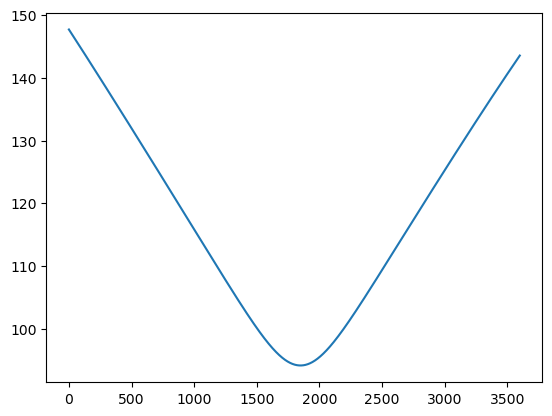

In [37]:
angles = angle_between_vectors(distance_vec, gs_coords)
print(angles[angles < 90])
print(min(angles))
plt.plot(angles)

In [21]:
a = np.array([[1, 1, 1], [2, 2, 2]])
b = np.array([[3, 3, 4], [2, 5, 2]])
print(np.sum(a * b, axis=1))

[10 18]


Satellite is visible: True


Satellite is visible: False


In [46]:
# later is DRAFT!!!!!

In [4]:
from astropy.coordinates import ITRS, GCRS, EarthLocation
from astropy import units as u
from astropy.time import Time

# Define the original epoch (for example, January 1, 2022)
original_epoch = Time("2022-01-01T00:00:00")

# Define the new epoch (for example, January 1, 2024)
new_epoch = Time("2024-01-01T00:00:00")

# Define the original ITRS coordinates (x, y, z in meters)
# Example: ITRS coordinates for the original epoch
original_itrs_coords = ITRS(
    x=4200000 * u.m, y=0 * u.m, z=5000000 * u.m, obstime=original_epoch
)

# Print the original ITRS coordinates
print(f"Original ITRS Coordinates at {original_epoch}:")
print(original_itrs_coords)

# Transform the ITRS coordinates to the new epoch
# First, you need to convert ITRS to GCRS (if needed) to get accurate results.
gcrs_coords = original_itrs_coords.transform_to(GCRS(obstime=original_epoch))

# Transform GCRS coordinates back to ITRS for the new epoch
new_itrs_coords = gcrs_coords.transform_to(ITRS(obstime=new_epoch))

# Print the new ITRS coordinates
print(f"New ITRS Coordinates at {new_epoch}:")
print(new_itrs_coords)

Original ITRS Coordinates at 2022-01-01T00:00:00.000:
<ITRS Coordinate (obstime=2022-01-01T00:00:00.000, location=(0., 0., 0.) km): (x, y, z) in m
    (4200000., 0., 5000000.)>
New ITRS Coordinates at 2024-01-01T00:00:00.000:
<ITRS Coordinate (obstime=2024-01-01T00:00:00.000, location=(0., 0., 0.) km): (x, y, z) in m
    (8.88188481e+08, 1.27686087e+09, 2.80167477e+08)>


In [3]:
from astropy.coordinates import EarthLocation, ITRS
from astropy.time import Time
from astropy import units as u

# Define Paris' approximate geographic coordinates
paris_location = EarthLocation(
    lat=48.8566 * u.deg, lon=2.3522 * u.deg, height=35 * u.m
)  # Paris altitude 35 meters

# Define two different epochs
epoch_2000 = Time("2000-01-01T00:00:00")
epoch_2020 = Time("2020-01-01T00:00:00")

# Get the ITRS coordinates of Paris at both epochs
paris_itrs_2000 = paris_location.get_itrs(obstime=epoch_2000)
paris_itrs_2020 = paris_location.get_itrs(obstime=epoch_2020)

# Print out the ITRS coordinates at both epochs
print(f"Paris ITRS coordinates at 2000: {paris_itrs_2000}")
print(f"Paris ITRS coordinates at 2020: {paris_itrs_2020}")

Paris ITRS coordinates at 2000: <ITRS Coordinate (obstime=2000-01-01T00:00:00.000, location=(0., 0., 0.) km): (x, y, z) in m
    (4200937.8043512, 172560.72143258, 4780107.69925048)>
Paris ITRS coordinates at 2020: <ITRS Coordinate (obstime=2020-01-01T00:00:00.000, location=(0., 0., 0.) km): (x, y, z) in m
    (4200937.8043512, 172560.72143258, 4780107.69925048)>
